In [192]:
# imports and globals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
BASE_DIRECTORY = "dataset"

COUNTRY_DATA = {
    "United Kingdom": {
        "population": 66440000, #2018
        "province": "",
    },
    "France": {
        "population": 66990000, #2019
        "province": "",
    },
    "Germany": {
        "population": 82790000, #2018
        "province": "",
    },
    "Spain": {
        "population":46660000, #2018
        "province": "",
    },
    "Italy" : {
        "population":60480000, #2018
        "province": "",
    },
    "China" : {
        "population": 59020000, # 2017 just Hubei
        "province": "Hubei",
    },
    "Korea, South": {
        "population": 51470000, #2017
        "province": "",
    }
}

In [ ]:
# load the datasets
confirmed = pd.read_csv(join(BASE_DIRECTORY, "time_series_covid_19_confirmed.csv"))
deaths = pd.read_csv(join(BASE_DIRECTORY, "time_series_covid_19_deaths.csv"))
recovered = pd.read_csv(join(BASE_DIRECTORY, "time_series_covid_19_recovered.csv"))

In [189]:

def load(country: str, state: str) -> pd.DataFrame:
    """
    returns a country as a pandas dataframes with confirmed, deaths, recovered as columns, dates as index
    """
    # could do the following as a loop but eh

    # confirmed
    country_df = confirmed[confirmed['Country/Region'] == country].replace(np.nan, "")
    state_df = country_df[country_df['Province/State'] == state]
    confirmed_result = state_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).T

    # deaths
    country_df = deaths[deaths['Country/Region'] == country].replace(np.nan, "")
    state_df = country_df[country_df['Province/State'] == state]
    deaths_result = state_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).T

    # recovered
    country_df = recovered[recovered['Country/Region'] == country].replace(np.nan, "")
    state_df = country_df[country_df['Province/State'] == state]
    recovered_result = state_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).T

    # combine the series to one dataframe
    df_result = pd.concat([confirmed_result, deaths_result, recovered_result], axis =1)
    df_result.columns = ["confirmed", "deaths", "recovered"]
    df_result.index = pd.to_datetime(df_result.index)

    return df_result


In [194]:
normalise = lambda x: x/POPULATIONS['United Kingdom'] * 100
for country in COUNTRY_DATA.keys():
    df = load(country, COUNTRY_DATA[country]['province'])
    COUNTRY_DATA[country]['data'] = df
    # Normalise data with population figures
    COUNTRY_DATA[country]['normalised_data'] = df.apply(normalise)


Text(0, 0.5, 'Percentage of the population')

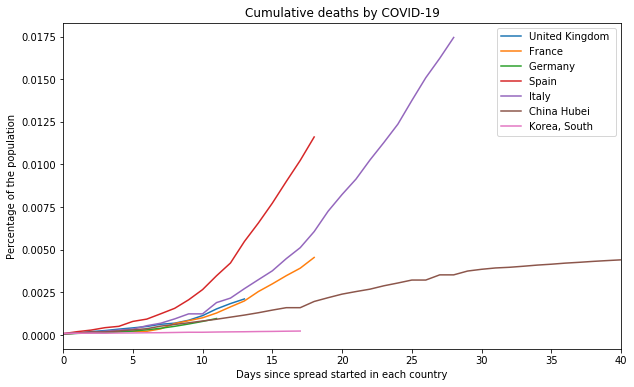

In [200]:
# Now we have normalised death values, we need normalised dates. We should only compare counties from the date the virus started killing
# Find the first day of a death for each country
first_day = lambda df: df.deaths[df.deaths <= 0.0001].index[-1]
# need to convert the index to days since the first day
convert_index = lambda df: df[df.index >= first_day(df)].reset_index()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for country in COUNTRY_DATA.keys():
    ax.plot(convert_index(COUNTRY_DATA[country]['normalised_data']).deaths)
ax.legend([country + " " + COUNTRY_DATA[country]['province'] for country in COUNTRY_DATA.keys()])
ax.set_xlim([0, 40])
plt.title("Cumulative deaths by COVID-19")
plt.xlabel("Days since spread started in each country")
plt.ylabel("Percentage of the population")